In [40]:
%load_ext autoreload
%autoreload 2
import terra
import numpy as np
import seaborn as sns
from domino.evaluate import run_sdm, score_sdms

import matplotlib.pyplot as plt
from meerkat.contrib.imagenet import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from domino.evaluate import run_sdm, score_sdms

df = score_sdms.out().load()

In [48]:
settings_df = df.iloc[df.reset_index().groupby(["run_sdm_run_id", "slice_idx"])['auroc'].idxmax().astype(int)]
print((settings_df["precision_at_10"] > 0.5).mean())
settings_df

0.5


,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision,target_synset,run_sdm_run_id,slice
1,1,0,0.986108,0.0,0.00,0.01,0.000000,0.011765,0.200000,0.976471,0.049317,building.n.01,12556,theater.n.01
7,2,0,0.960818,0.0,0.04,0.01,0.000000,0.008621,0.025862,0.215517,0.025826,building.n.01,12557,greenhouse.n.01
12,2,0,0.995531,1.0,1.00,1.00,0.163399,0.326797,0.624183,0.401961,0.968504,vehicle.n.01,12558,aircraft.n.01
16,1,0,0.913775,1.0,0.92,0.51,0.119298,0.178947,0.231579,0.680702,0.047156,dog.n.01,12559,afghan_hound.n.01
22,2,0,0.972611,1.0,0.84,0.50,0.186813,0.274725,0.373626,1.000000,0.032858,food.n.01,12560,bread.n.01
28,3,0,0.952093,0.6,0.52,0.49,0.091241,0.178832,0.302920,0.343066,0.294671,vehicle.n.01,12561,beach_wagon.n.01
32,2,0,0.994057,0.9,0.96,0.92,0.183150,0.336996,0.611722,0.630037,0.704918,vehicle.n.01,12562,cab.n.03
38,3,0,0.963479,0.0,0.00,0.04,0.000000,0.076531,0.091837,0.265306,0.156156,food.n.01,12563,punch.n.02
44,4,0,0.991995,0.4,0.16,0.13,0.000000,0.339623,0.452830,1.000000,0.031642,cat.n.01,12564,cougar.n.01
47,2,0,0.977885,0.1,0.08,0.09,0.067961,0.067961,0.242718,1.000000,0.033452,vegetable.n.01,12565,pepper.n.04


In [49]:
from domino.evaluate import run_sdm, score_sdm_explanations

df = score_sdm_explanations.out().load()
settings_df = df.iloc[df.reset_index().groupby(["run_sdm_run_id", "slice_idx"])['min_rank'].idxmin().astype(int)]
settings_df

,pred_slice_idx,slice_idx,slice_synset,mean_reciprocal_rank,max_reciprocal_rank,mean_rank,min_rank,target_synset,run_sdm_run_id,slice
4,4,0,theater.n.01,0.000044,0.000068,25700.666667,14736,building.n.01,12556,theater.n.01
7,2,0,greenhouse.n.01,0.001491,0.004219,29227.333333,237,building.n.01,12557,greenhouse.n.01
10,0,0,aircraft.n.01,0.016129,0.016129,62.000000,62,vehicle.n.01,12558,aircraft.n.01
16,1,0,afghan_hound.n.01,0.000026,0.000026,38547.000000,38547,dog.n.01,12559,afghan_hound.n.01
22,2,0,bread.n.01,0.031250,0.031250,32.000000,32,food.n.01,12560,bread.n.01
28,3,0,beach_wagon.n.01,0.001541,0.003021,8412.000000,331,vehicle.n.01,12561,beach_wagon.n.01
32,2,0,cab.n.03,0.113988,0.333333,16589.750000,3,vehicle.n.01,12562,cab.n.03
35,0,0,punch.n.02,0.000107,0.000107,9332.000000,9332,food.n.01,12563,punch.n.02
44,4,0,cougar.n.01,0.126562,0.500000,21477.000000,2,cat.n.01,12564,cougar.n.01
47,2,0,pepper.n.04,0.000460,0.000460,2174.000000,2174,vegetable.n.01,12565,pepper.n.04


In [44]:
inp = run_sdm.inp(run_id=12539, load=True)
data_dp, emb_dp = inp["data_dp"], inp["emb_dp"]

data_dp = data_dp.lz[data_dp["split"].isin(["valid", "test"])].merge(
    emb_dp[["image_id", "emb"]], on="image_id"
)

In [46]:
_, word_dp = run_sdm.out(run_id=12539, load=True)
word_dp.lz[(-word_dp["pred_slices"][:, 2]).argsort()[:10]]


,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn),frequency (PandasSeriesColumn)
0,free-throw,"np.ndarray(shape=(5,))",600
1,tip-off,"np.ndarray(shape=(5,))",621
2,dunking,"np.ndarray(shape=(5,))",395
3,basketball,"np.ndarray(shape=(5,))",247064
4,layup,"np.ndarray(shape=(5,))",825
5,game-winner,"np.ndarray(shape=(5,))",606
6,three-pointer,"np.ndarray(shape=(5,))",1083
7,parquet,"np.ndarray(shape=(5,))",796
8,backcourt,"np.ndarray(shape=(5,))",403
9,triple-double,"np.ndarray(shape=(5,))",959


In [23]:
from domino.sdm import MixtureModelSDM, SpotlightSDM
sdm = MixtureModelSDM(
    n_slices=5, 
    n_clusters=25, 
    weight_y_log_likelihood=10, 
    init_params="error",
    emb="emb",
    pca_components=128 
)

sdm.fit(data_dp.lz[data_dp["split"] == "valid"])
dp = sdm.transform(data_dp.lz[data_dp["split"] == "test"])

 50%|█████     | 50/100 [00:07<00:07,  7.02it/s]


In [24]:
from domino.metrics import compute_sdm_metrics
slice_idx = 0

metrics_df = compute_sdm_metrics(dp)
metrics_df[metrics_df["slice_idx"] == slice_idx].sort_values(by="auroc", ascending=False)

,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision
3,3,0,0.988581,0.8,0.80,0.66,0.129496,0.237410,0.428058,0.848921,0.319783
1,1,0,0.780940,0.1,0.04,0.04,0.003597,0.014388,0.021583,0.151079,0.005353
4,4,0,0.724505,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
0,0,0,0.210267,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0,0.128898,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
from domino.emb.clip import embed_words
pred_slice_idx = 3
words_dp = embed_words.out(5143).load().lz[:int(1.1e4)]
expl_dp = sdm.explain(words_dp)
expl_dp.lz[(-expl_dp["pred_slices"][:, pred_slice_idx]).argsort()[:10]]

KeyError: "DataPanel does not have columns {'slices'}"

In [9]:
from domino.metrics import compute_expl_metrics
compute_expl_metrics(expl_dp, ["cab.n.03"])

,pred_slice_idx,slice_idx,slice_synset,mean_reciprocal_rank,max_reciprocal_rank,mean_rank,min_rank
0,0,0,cab.n.03,0.001425,0.002146,944.0,466
1,1,0,cab.n.03,0.000099,0.000106,10154.5,9437
2,2,0,cab.n.03,0.625000,1.000000,2.5,1
3,3,0,cab.n.03,0.005121,0.008333,322.0,120
4,4,0,cab.n.03,0.000192,0.000193,5216.5,5169


In [62]:
inp = run_sdm.inp(run_id=12217)
inp

{'data_dp': {'__run_dir__': '/home/sabri/terra/slice/tasks/slices/abstract/build_setting/_runs/11945', '__key__': '66fea19f0131413290b3ce78583d4a98', '__type__': <class 'meerkat.datapanel.DataPanel'>, '__id__': 189782},
 'emb_dp': {'__run_dir__': '/home/sabri/terra/slice/tasks/emb/clip/embed_images/_runs/6662', '__key__': '662684d6186f4424b1db9198d36166f8', '__type__': <class 'meerkat.datapanel.DataPanel'>, '__id__': 165078},
 'model': None,
 'id_column': 'image_id',
 'sdm_class': domino.sdm.gmm.MixtureModelSDM,
 'sdm_config': {'n_slices': 5, 'weight_y_log_likelihood': 10, 'emb': 'emb'},
 'build_setting_run_id': {'__run_dir__': '/home/sabri/terra/slice/tasks/evaluate/run_sdm/_runs/12217', '__key__': '6cdd11850e6840e196d73fa5437ed271', '__type__': <class 'numpy.int64'>, '__id__': 190598},
 'dataset': 'imagenet',
 'index': '14',
 'n': {'__run_dir__': '/home/sabri/terra/slice/tasks/evaluate/run_sdm/_runs/12217', '__key__': '6cf2204fa31b49d59c1dd661529991c6', '__type__': <class 'numpy.int6

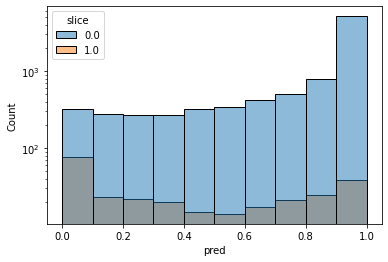

In [48]:
plot_df = pd.DataFrame(
    {"pred": dp["pred"], "slice": dp["slices"][:, slice_idx], "target": dp["target"]}
)
sns.histplot(
    data=plot_df[plot_df["target"] == 1],
    x="pred",
    hue="slice",
    stat="count",
    common_norm=not False,
    binwidth=0.1,
)
plt.yscale("log")


In [53]:
plot_df[(plot_df["pred"] < 0.2) & (plot_df["target"] == 1)].slice.mean()

0.14184397163120568

,image_id (PandasSeriesColumn),path (PandasSeriesColumn),index (PandasSeriesColumn),image (ImageColumn),name (PandasSeriesColumn),synset_pos_offset (PandasSeriesColumn),synset (PandasSeriesColumn),target (NumpyArrayColumn),slices (NumpyArrayColumn),input (ImageColumn),id (PandasSeriesColumn),pred (NumpyArrayColumn),split (PandasSeriesColumn),emb (NumpyArrayColumn),pred_slices (NumpyArrayColumn)
0,n01860187_22552,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01860187/n01860187_22552.JPEG,129869,,"black swan, Cygnus atratus",n01860187,black_swan.n.01,1,"np.ndarray(shape=(1,))",,n01860187_22552,0.010011,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
1,n01860187_1114,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01860187/n01860187_1114.JPEG,129463,,"black swan, Cygnus atratus",n01860187,black_swan.n.01,1,"np.ndarray(shape=(1,))",,n01860187_1114,0.168325,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
2,n01847000_4207,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01847000/n01847000_4207.JPEG,126491,,drake,n01847000,drake.n.02,1,"np.ndarray(shape=(1,))",,n01847000_4207,0.839594,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
3,n01855672_4563,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01855672/n01855672_4563.JPEG,128830,,goose,n01855672,goose.n.01,1,"np.ndarray(shape=(1,))",,n01855672_4563,0.982692,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
4,n01847000_1459,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01847000/n01847000_1459.JPEG,126057,,drake,n01847000,drake.n.02,1,"np.ndarray(shape=(1,))",,n01847000_1459,0.603834,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
5,n01860187_5026,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01860187/n01860187_5026.JPEG,130379,,"black swan, Cygnus atratus",n01860187,black_swan.n.01,1,"np.ndarray(shape=(1,))",,n01860187_5026,0.017268,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
6,n01847000_16362,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01847000/n01847000_16362.JPEG,126212,,drake,n01847000,drake.n.02,1,"np.ndarray(shape=(1,))",,n01847000_16362,0.843559,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
7,n01860187_37570,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01860187/n01860187_37570.JPEG,130253,,"black swan, Cygnus atratus",n01860187,black_swan.n.01,1,"np.ndarray(shape=(1,))",,n01860187_37570,0.382149,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
8,n01860187_1702,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01860187/n01860187_1702.JPEG,129701,,"black swan, Cygnus atratus",n01860187,black_swan.n.01,1,"np.ndarray(shape=(1,))",,n01860187_1702,0.540981,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
9,n01860187_38456,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n01860187/n01860187_38456.JPEG,130271,,"black swan, Cygnus atratus",n01860187,black_swan.n.01,1,"np.ndarray(shape=(1,))",,n01860187_38456,0.093921,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"

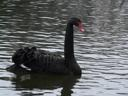
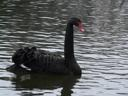
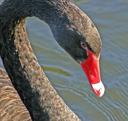
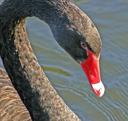
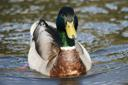
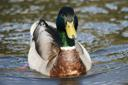
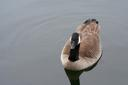
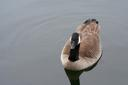
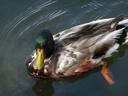
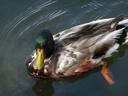
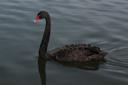
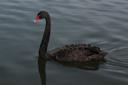
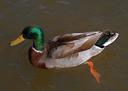
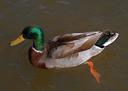
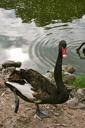
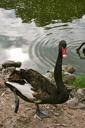
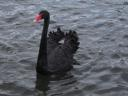
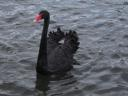
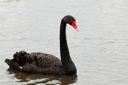
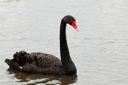

In [19]:

dp.lz[dp["pred_slices"].data[:, pred_slice_idx].argsort()[-10:]]#[["object_image", "target", "slice"]]